/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


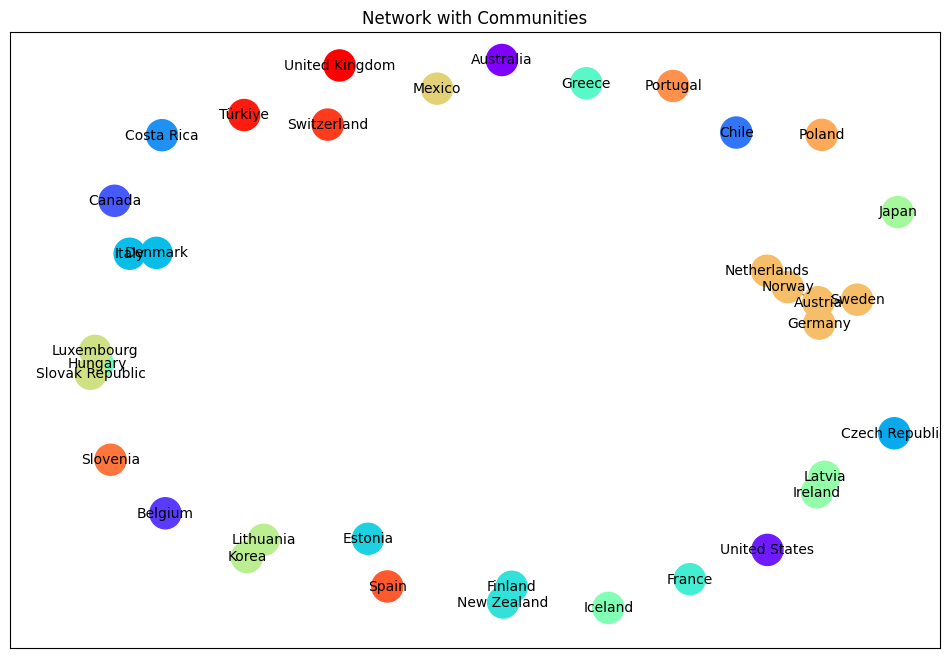

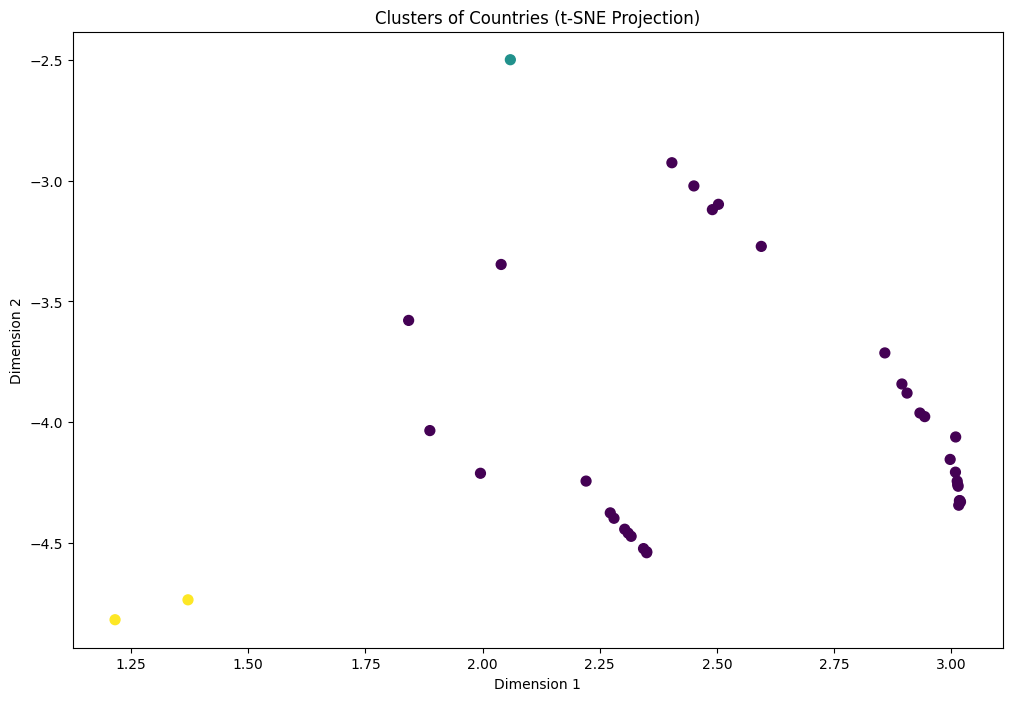

In [1]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from community import community_louvain

# Load the dataset
file_path = 'Nationality_Acquisition.csv'
data = pd.read_csv(file_path)

data = data.drop(columns=data.columns[0])

data.columns = ['Country', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

# Convert year columns to numeric
for year in data.columns[1:]:
    data[year] = pd.to_numeric(data[year], errors='coerce')

# Drop rows with missing countries or all NaN year values
data = data.dropna(subset=['Country'])
data = data.dropna(how='all', subset=data.columns[1:])

# Define the network structure
G = nx.Graph()

# Add nodes with attributes
for index, row in data.iterrows():
    G.add_node(row['Country'], **row.iloc[1:].to_dict())

# Add edges based on similarity (e.g., correlation)
threshold = 0.8
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        country1, country2 = data.iloc[i]['Country'], data.iloc[j]['Country']
        similarity = data.iloc[i, 1:].corr(data.iloc[j, 1:])
        if similarity >= threshold:
            G.add_edge(country1, country2, weight=similarity)

# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

# Add centrality measures as node attributes
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')

# Community detection using Louvain
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'community')

# Visualize the network with community information
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
colors = [communities[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.rainbow, node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Network with Communities")
plt.show()

# Fill NaN values in the attributes DataFrame with the mean of each column
attributes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
attributes = attributes.iloc[:, :-1]  # Remove community column if present
attributes = attributes.fillna(attributes.mean())

# Scale the attributes
scaler = StandardScaler()
scaled_attributes = scaler.fit_transform(attributes)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(scaled_attributes)
attributes['cluster'] = kmeans.labels_

# Dimensionality reduction for visualization (t-SNE)
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(scaled_attributes)

# Visualize clusters in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=attributes['cluster'], cmap='viridis', s=50)
plt.title("Clusters of Countries (t-SNE Projection)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# Save the results
attributes.to_csv('network_analysis_results.csv', index=True)


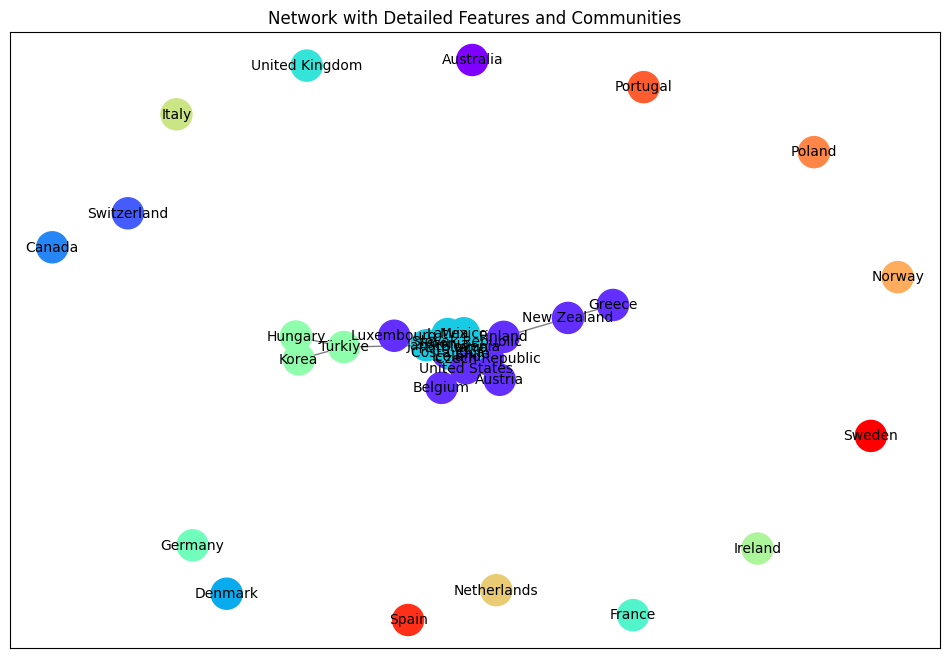

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np


file_path = 'Nationality_Acquisition.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=data.columns[0])
data.columns = ['Country', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

# Ensure numeric data for correlation
for year in data.columns[1:]:
    data[year] = pd.to_numeric(data[year], errors='coerce')

# Drop missing countries and all NaN year values
data = data.dropna(subset=['Country'])
data = data.dropna(how='all', subset=data.columns[1:])

# Feature Vector Construction
# The feature vector for each country is defined as the normalized yearly nationality acquisition data (2011–2021).
scaler = StandardScaler()
feature_vectors = scaler.fit_transform(data.iloc[:, 1:].fillna(0))  # Replace NaN with 0 for this example
data['Feature_Vector'] = list(feature_vectors)

# Detailed Connection Criteria
# Connections are based on the Pearson correlation of feature vectors
threshold = 0.8
G = nx.Graph()

# Add nodes with feature vectors as attributes
for index, row in data.iterrows():
    G.add_node(row['Country'], feature_vector=row['Feature_Vector'])

# Add edges based on correlation
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        country1, country2 = data.iloc[i]['Country'], data.iloc[j]['Country']
        vec1, vec2 = data.iloc[i]['Feature_Vector'], data.iloc[j]['Feature_Vector']
        similarity = np.corrcoef(vec1, vec2)[0, 1]  # Compute correlation
        if similarity >= threshold:
            G.add_edge(country1, country2, weight=similarity)


# Extracting the correlation matrix for documentation
correlation_matrix = np.corrcoef(feature_vectors, rowvar=True)
correlation_df = pd.DataFrame(correlation_matrix, index=data['Country'], columns=data['Country'])

# Save the correlation matrix to a CSV file
correlation_df.to_csv('correlation_matrix.csv')

# Centrality measures and community detection
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')

# Community detection using Louvain method
from community import community_louvain
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'community')

# Save the network analysis results with detailed feature vector info
node_attributes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
node_attributes.to_csv('network_analysis_with_features.csv', index=True)

# Visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
colors = [communities[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.rainbow, node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Network with Detailed Features and Communities")
plt.show()


In [3]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.8 MB/s eta 0:00:00


In [4]:
# Install pyvis if not already installed
# !pip install pyvis

from pyvis.network import Network
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import StandardScaler

# Reload dataset
file_path = 'Nationality_Acquisition.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=data.columns[0])
data.columns = ['Country', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

# Ensure numeric data for correlation
for year in data.columns[1:]:
    data[year] = pd.to_numeric(data[year], errors='coerce')

# Drop missing countries and all NaN year values
data = data.dropna(subset=['Country'])
data = data.dropna(how='all', subset=data.columns[1:])

# Feature Vector Construction
scaler = StandardScaler()
feature_vectors = scaler.fit_transform(data.iloc[:, 1:].fillna(0))  # Replace NaN with 0 for simplicity
data['Feature_Vector'] = list(feature_vectors)

# Create graph based on correlation
threshold = 0.8
G = nx.Graph()
for index, row in data.iterrows():
    G.add_node(row['Country'], feature_vector=row['Feature_Vector'])
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        country1, country2 = data.iloc[i]['Country'], data.iloc[j]['Country']
        vec1, vec2 = data.iloc[i]['Feature_Vector'], data.iloc[j]['Feature_Vector']
        similarity = np.corrcoef(vec1, vec2)[0, 1]  # Compute correlation
        if similarity >= threshold:
            G.add_edge(country1, country2, weight=similarity)

# Community detection
from community import community_louvain
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'community')

# Create an interactive visualization
net = Network(notebook=True, width="800px", height="800px", directed=False)

# Add nodes and edges to the interactive graph
for node, attributes in G.nodes(data=True):
    net.add_node(node, label=node, group=attributes['community'])

for source, target, attributes in G.edges(data=True):
    net.add_edge(source, target, value=attributes['weight'])

# Save and display the network
net.show("interactive_network.html")


interactive_network.html
